In [ ]:
import time
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torch.autograd import grad
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.optim.lr_scheduler import ExponentialLR

# raissi plots
from scipy.interpolate import griddata
from itertools import product, combinations

from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR
from tqdm import tqdm_notebook as tqdm
import minterpy as mp
from pinnutils import *

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [16]:
# tuning parameters for experiment
# fig D.1 in paper generated for scales 1-6 and averaged over 5 seeds

scale  = 6 # control frequency of solution omega=scale*pi
method = 0 # 0 - uniform, 1 - inverse-Dirichlet, 2 - max/avg, 3 - MGDA, 4 - optimal
seed   = 1 # rng seed

In [26]:
def Hk_coeff(deg, k_sob):
    mi = mp.multi_index.MultiIndex.from_degree(spatial_dimension=2, poly_degree=deg, lp_degree=np.inf)
    ord_grid =mp.grid.Grid(mi).unisolvent_nodes
    can_bdy = np.array([[-1, -1, 0], [1, 1, 0]])
    residual_bdy = can_bdy
    un_grid = set_gen_sob(deg+1, can_bdy, 
                         np.polynomial.legendre.leggauss(deg+1)[0],
                         np.polynomial.legendre.leggauss(deg+1)[1])[0]
    un_weights = set_gen_sob(deg+1, can_bdy, 
                         np.polynomial.legendre.leggauss(deg+1)[0],
                         np.polynomial.legendre.leggauss(deg+1)[1])[1]#np.polynomial.legendre.leggauss(n+1)[1]
    ord_index = [[ i for i,j in enumerate(un_grid) if j[0] == ord_grid[k][0] and 
                 j[1] == ord_grid[k][1]][0] for k in range(len(ord_grid))]
    ord_sc_weights = un_weights[ord_index]
    ord_sc_grid = un_grid[ord_index]
    W_HK = []
    if k_sob == 1 or k_sob == 2 or k_sob ==3 or k_sob==4:
        coeff_L_x = []
        coeff_L_y = []
        for i in range(len(mi)):
            alpha = np.zeros(len(mi))
            alpha[i] = 1 
            #custom_grid = mp.Grid(mi,generating_values = grid_r[0][:,0])
            lag_poly = mp.LagrangePolynomial(alpha, mi)
            derivator_lag_poly = mp.Derivator(lag_poly, mp.LagrangePolynomial)
            d_c = derivator_lag_poly.get_gradient_poly().coeffs
            #alpha = np.divide(1,(1+d_c))
            #sobolev_w = np.divide(lag_poly.coeffs,2)
            coeff_L_x.append(d_c[:,0])
            coeff_L_y.append(d_c[:,1])
        h_w_x = torch.einsum('ab,b->ab',
                 torch.tensor(coeff_L_x),torch.Tensor(ord_sc_weights))
        h_w_y = torch.einsum('ab,b->ab',
                     torch.tensor(coeff_L_y),torch.Tensor(ord_sc_weights))
        H_x = torch.einsum('ab,cb->ac',torch.tensor(coeff_L_x), h_w_x)
        H_y = torch.einsum('ab,cb->ac',torch.tensor(coeff_L_y), h_w_y)
        Cx = 1/((deg)**2)
        H_1 = [H_x*Cx, H_y*Cx]
        W_HK.append(H_1)
        if k_sob == 2 or k_sob ==3 or k_sob==4:
            HxH_x=torch.einsum('ab,cd->abcd',torch.tensor(coeff_L_x),torch.tensor(coeff_L_x))
            HxH_y=torch.einsum('ab,cd->abcd',torch.tensor(coeff_L_y),torch.tensor(coeff_L_y))
            HxH = [HxH_x, HxH_y]
            ind_H2 = [[0,0],[0,1],[1,1]]
            H_2 = []
            for i in range(len(ind_H2)):
                H_2.append(torch.einsum('abcd,bd->ac',Cx*HxH[ind_H2[i][0]],H_1[ind_H2[i][1]]))
            W_HK.append(H_2)
            if  k_sob == 3 or k_sob == 4:
                H_3 = []
                ind_H3 = [[0,0], [0,1],[0,2],[1,0],[1,2]]
                for i in range(len(ind_H3)):
                    H_3.append(torch.einsum('abcd,bd->ac',
                                            Cx*HxH[ind_H3[i][0]],H_2[ind_H3[i][1]]))
                W_HK.append(H_3)
                if k_sob == 4:
                    H_4 = []
                    ind_H4 = [[0,0],[0,1],[0,2],[0,3],[0,4],[1,0],[1,3],[1,4]]
                    for i in range(len(ind_H4)):
                        H_4.append(torch.einsum('abcd,bd->ac',Cx*HxH[ind_H4[i][0]],
                                                H_3[ind_H4[i][1]]))
                    W_HK.append(H_4)
    return ord_sc_grid.T, ord_sc_weights, W_HK
def Hk_coeff_bdy(deg, k_sob):
    mi = mp.multi_index.MultiIndex.from_degree(spatial_dimension=1, poly_degree=deg, lp_degree=np.inf)
    ord_grid =mp.grid.Grid(mi).unisolvent_nodes.T[0]
    un_grid , un_weights = np.polynomial.legendre.leggauss(deg+1)
    ord_index = [[ i for i,j in enumerate(un_grid) if j == ord_grid[k]][0]
                 for k in range(len(ord_grid))]
    Cx = 1/((deg)**2)
    ord_sc_weights = Cx*un_weights[ord_index]
    ord_sc_grid = un_grid[ord_index]
    weights = []
    if k_sob == 1 or k_sob == 2 or k_sob ==3 or k_sob==4:
        coeff_L_x = []
        for i in range(len(mi)):
            alpha = np.zeros(len(mi))
            alpha[i] = 1 
            lag_poly = mp.LagrangePolynomial(alpha, mi)
            derivator_lag_poly = mp.Derivator(lag_poly, mp.LagrangePolynomial)
            d_c = derivator_lag_poly.get_gradient_poly().coeffs
            coeff_L_x.append(d_c[:,0])
        h_w_x = torch.einsum('ab,b->ab',
                 torch.tensor(coeff_L_x),torch.Tensor(ord_sc_weights))
        H_1 = torch.einsum('ab,cb->ac',Cx*torch.tensor(coeff_L_x), h_w_x)
        weights.append(H_1)
        if k_sob == 2 or k_sob ==3 or k_sob==4:
            HxH_x=torch.einsum('ab,cd->abcd',torch.tensor(coeff_L_x),torch.tensor(coeff_L_x)) 
            H_2 = torch.einsum('abcd,bd->ac',Cx*HxH_x,H_1)
            weights.append(H_2)
            if  k_sob == 3 or k_sob == 4:
                H_3 = torch.einsum('abcd,bd->ac',Cx*HxH_x,H_2)
                weights.append(H_3)
                if k_sob == 4:
                    H_4 = torch.einsum('abcd,bd->ac',Cx*HxH_x,H_3)
                    weights.append(H_4)
    return ord_sc_grid, ord_sc_weights, weights

In [17]:
# setup training data and ground truth
def poisson_equation(x,y,omega):
    return np.cos(omega*x)*np.sin(omega*y)

x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)

omega = scale*np.pi
xx,yy = np.meshgrid(x,y)
u_sol = poisson_equation(xx,yy,omega)

X = np.vstack([xx.ravel(), yy.ravel()]).T

xb = np.linspace(0,1,100)
yb = np.linspace(0,1,100)

# X boundaries
lb   = np.min(xb)*np.ones((yb.shape))
Xlb  = np.vstack((lb,yb)).T
UXlb = np.cos(omega*Xlb[:,0])*np.sin(omega*Xlb[:,1])

rb   = np.max(xb)*np.ones((yb.shape))
Xrb  = np.vstack((rb,yb)).T
UXrb = np.cos(omega*Xrb[:,0])*np.sin(omega*Xrb[:,1])
    
# Y boundaries
lb   = np.min(yb)*np.ones((xb.shape))
Ylb  = np.vstack((xb,lb)).T
UYlb = np.cos(omega*Ylb[:,0])*np.sin(omega*Ylb[:,1])
    
rb   = np.max(yb)*np.ones((xb.shape))
Yrb  = np.vstack((xb,rb)).T
UYrb = np.cos(omega*Yrb[:,0])*np.sin(omega*Yrb[:,1])

#plt.(u_sol, cmap="Spectral", origin="bottom")
#plt.xticks(np.arange(0,len(x)+1,25), np.arange(0, 1.1, 0.25))
#plt.yticks(np.arange(0,len(y)+1,25), np.arange(0, 1.1, 0.25))
#plt.xlabel(r"$x$")
#plt.ylabel(r"$y$")
#plt.colorbar()

In [18]:
np.random.seed(seed)
torch.manual_seed(seed)

# initialize training tensors
idxs = np.random.choice(X.shape[0], 2500, replace=False)
X_train = torch.tensor(X[idxs], dtype=torch.float32, requires_grad=True, device=device)

X_rb = torch.tensor(Xrb, dtype=torch.float32, device=device)
X_lb = torch.tensor(Xlb, dtype=torch.float32, device=device)

Y_rb = torch.tensor(Yrb, dtype=torch.float32, device=device)
Y_lb = torch.tensor(Ylb, dtype=torch.float32, device=device)

U_X_rb = torch.tensor(UXrb, dtype=torch.float32, device=device).reshape(100,1)
U_X_lb = torch.tensor(UXlb, dtype=torch.float32, device=device).reshape(100,1)
U_Y_rb = torch.tensor(UYrb, dtype=torch.float32, device=device).reshape(100,1)
U_Y_lb = torch.tensor(UYlb, dtype=torch.float32, device=device).reshape(100,1)

TD = np.concatenate([X[idxs], Xrb, Xlb, Yrb, Ylb], 0)

# compute mean and std of training data
X_mean = torch.tensor(np.mean(TD, axis=0, keepdims=True), dtype=torch.float32, device=device)
X_std  = torch.tensor(np.std(TD, axis=0, keepdims=True), dtype=torch.float32, device=device)

In [19]:
def poisson_residual(uhat, data, omega):
    poly = torch.ones_like(uhat)
    
    du = grad(outputs=uhat, inputs=data, 
              grad_outputs=torch.ones_like(uhat), create_graph=True)[0]
    
    dudx = du[:,0:1]
    dudy = du[:,1:2]
    
    dudxx = grad(outputs=dudx, inputs=data, 
              grad_outputs=torch.ones_like(uhat), create_graph=True)[0][:,0:1]
    dudyy = grad(outputs=dudy, inputs=data, 
              grad_outputs=torch.ones_like(uhat), create_graph=True)[0][:,1:2]
    
    xin = data[:,0:1]
    yin = data[:,1:2]
    
    source = -2.0*omega*omega*torch.cos(omega*xin)*torch.sin(omega*yin) + 0*uhat
    
    residual = dudxx + dudyy - source
                
    return residual

In [20]:
np.random.seed(seed)
torch.manual_seed(seed)

net = PINN(sizes=[2,50,50,50,50,50,1], mean=X_mean, std=X_std, seed=seed, activation=torch.nn.Tanh()).to(device)
print("#parameters:", sum(p.numel() for p in net.parameters() if p.requires_grad))

n_epochs   = 1000
lamb       = 1
alpha_ann  = 0.5
mm         = 5

# logging
losses_bc  = []
losses_reg = []
lambs      = []

params = [{'params': net.parameters(), 'lr': 1e-3}]

optimizer = Adam(params)
scheduler = MultiStepLR(optimizer, [10000,20000,30000], gamma=0.1)

print("training with shape", X_train.size())

start = time.time()
for epoch in range(n_epochs):
    net.train()
    optimizer.zero_grad()
    uhat  = net(X_train)
    res   = poisson_residual(uhat, X_train, omega)
    l_reg = torch.mean((res)**2)
    stdr  = 0
    maxr  = 0
    G_reg = 0
    with torch.no_grad():
        if epoch % mm == 0:
            if method == 1:
                stdr = loss_grad_std(l_reg, net)
            if method == 2:
                maxr, _ = loss_grad_max(l_reg, net)
            if method == 3:
                G_reg = network_gradient(l_reg, net)
                
    predl = net(X_lb)
    predr = net(X_rb)
    l_bc  = torch.mean((predl - U_X_lb)**2, dim=0)
    l_bc += torch.mean((predr - U_X_rb)**2, dim=0)
 
    predl = net(Y_lb)
    predr = net(Y_rb)
    l_bc += torch.mean((predl - U_Y_lb)**2, dim=0)
    l_bc += torch.mean((predr - U_Y_rb)**2, dim=0)
    
    with torch.no_grad():
        if epoch % mm == 0:
            if method == 1:
                # inverse-dirichlet
                stdb = loss_grad_std(l_bc, net)

                lamb_hat = stdr/stdb
                lamb     = (1-alpha_ann)*lamb + alpha_ann*lamb_hat
                lambs.append(lamb.item())
            elif method == 2:
                # max/avg
                _, meanu = loss_grad_max(l_bc, net, lambg=lamb)  
                
                lamb_hat = maxr/meanu
                lamb     = (1-alpha_ann)*lamb + alpha_ann*lamb_hat
                lambs.append(lamb.item()) 
            elif method == 3:
                # mgda
                G_bc = network_gradient(l_bc, net)
                
                M = torch.zeros((torch.numel(G_reg), 2), dtype=torch.float32, device=device)
                M[:,0] = G_reg
                M[:,1] = G_bc
                        
                c_ = solver_mine(torch.matmul(M.T, M).cpu().numpy(), 2, 1e-6, maxiter=1000)
                lambs.append([c_[0].item(), c_[1].item()])
            elif method == 4:
                # optimal
                lamb = 1.0/(1.0 + omega**4)
            else:
                # uniform
                lamb = 1
                
    if method == 1 or method == 2:
        loss = l_reg + lamb*l_bc
    elif method == 3:
        loss = c_[0]*l_reg + c_[1]*l_bc
    elif method == 4:
        loss = lamb*l_reg + (1.0 - lamb)*l_bc
    else:
        loss = l_reg + l_bc

    losses_bc.append(l_bc.item())
    losses_reg.append(l_reg.item())
    
    loss.backward()

    optimizer.step()
    scheduler.step()
    
    if epoch % 1 == 0:
        print("epoch {}/{}, loss={:.7f}, lambda={:.4f}\t\t\t"
          .format(epoch+1, n_epochs, loss.item(), lamb), end="\r")

#    # save model   
#    if epoch % 5000 == 0:
#        torch.save(net, './models/poisson_meth' + str(method) + '_scale' + str(scale) + '_5L' + '_N2500' + '_ep' + str(epoch)  + '_' + "tanh" + "_seed"+ str(seed) + '.pth')
#        
#        mdict = {
#           "epoch": epoch,
#           "t": (time.time() - start),
#           "l_bc":  losses_bc,
#           "l_reg": losses_reg,
#           "lamb": lambs
#        }
#
#        sio.savemat("./results/poisson_param_track_N2500_scale{}_method{}_seed{}".format(scale, method, seed), mdict)

elapsed_time = time.time() - start
print('CPU time =', elapsed_time)

#parameters: 10401
training with shape torch.Size([2500, 2])
CPU time = 10.384955883026123984, lambda=1.0000					


pred rel. l2-error = 8.163827e-01
pred rel. linf-error = 2.759674e+00


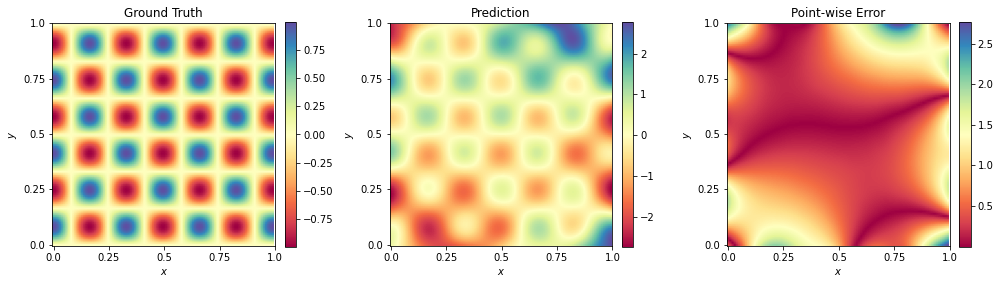

In [25]:
inp = torch.tensor(X, dtype=torch.float32, device=device)
out = net(inp).cpu().data.numpy().reshape(u_sol.shape)

print("pred rel. l2-error = {:e}".format(np.linalg.norm(out.reshape(-1)-u_sol.reshape(-1))/np.linalg.norm(out.reshape(-1))))
print("pred rel. linf-error = {:e}".format(abs(max(out.reshape(-1)-u_sol.reshape(-1)))))

plt.subplot(1,3,1)
plt.imshow(u_sol, cmap="Spectral", origin="lower")
plt.xticks(np.arange(0,len(x)+1,25), np.arange(0, 1.1, 0.25))
plt.yticks(np.arange(0,len(y)+1,25), np.arange(0, 1.1, 0.25))
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Ground Truth")
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1,3,2)
plt.imshow(out, cmap="Spectral", origin="lower")
plt.xticks(np.arange(0,len(x)+1,25), np.arange(0, 1.1, 0.25))
plt.yticks(np.arange(0,len(y)+1,25), np.arange(0, 1.1, 0.25))
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Prediction")
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1,3,3)
plt.imshow(np.abs(out-u_sol)/np.max(np.abs(u_sol)), cmap="Spectral", origin="lower")
plt.xticks(np.arange(0,len(x)+1,25), np.arange(0, 1.1, 0.25))
plt.yticks(np.arange(0,len(y)+1,25), np.arange(0, 1.1, 0.25))
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Point-wise Error")
plt.colorbar(fraction=0.046, pad=0.04)

plt.gcf().set_size_inches(14,4)
plt.tight_layout()